## 2.7 The Influence of Network Topologes

In Sec. 2.6, we discussed the convergence property of the average consensus algorithm. Recalling from Theorem 1 in Sec. 2.6 that $x_i^{(k)}$ generated by average consensus will converge to $\bar{x}^{(0)} = \frac{1}{n}\sum_{i=1}^n x_i^{(0)}$ at linear rate, i.e., 

$$\|x_i^{(k)} - \bar{x}^{(0)}\| \le \rho^k \|X^{(0)}\|_F$$

where $\rho = \rho(W - \frac{1}{n}\mathbf{1}\mathbf{1}^T) < 1$. The constant $\rho$, which is affected by the combination matrix and hence the network topology, decides the convergence rate of the average consensus algorithm. In this section we discuss how common network topologies influence the communication efficiency and convergence rate of average consensus.

The following table summarizes the spectral radius and maximum degree of some common network topologes. The combination matrix of the undirected topologies, i.e., the ring, 2D-mesh, and fully-connected topology, are generated through the Matropolis-Hastings  rule (see Sec. 2.3), while the combination matrix of exponential-2 topology (which is a directed network) is genereted through the Averaging rule (see Sec. 2.4). 


| Network topology | spectral radius ($\rho(W-\frac{1}{n}\mathbf{1}\mathbf{1}^T)$) | maximum degree |
| -: | :-: | :-: |
| Undirected Ring | $1-O(\frac{1}{n^2})$ | 2 |
| Undirected 2D-Mesh | $1-O(\frac{1}{n})$ | 4 |
| Exponential-2 | $1-O(\frac{1}{\ln(n)})$ | $\ln(n)$ |
| Fully connected| $0$ |$n-1$ |  

### 2.7.1 Network influence on convergence rate

According to the discussion in the very begining, we conclude that smaller $\rho$ implies faster convergence. Generally speaking, a dense network will enable average consensus to converge faster. In the extreme example of fully connected network, it holds that $W=\frac{1}{n}\mathbf{1}\mathbf{1}^T$ and hence $\rho = 0$. Therefore, averge consensus over fully connected network will converge to the global average via one step of recursion. In contrast, it holds that $\rho \to 1$ as $n \to \infty$ for ring and 2D-mesh topology, which implies that average consensus over these two topologies will converge very slow for large ring or 2D-mesh. 

### 2.7.2 Network influence on communication efficiency
Network topology also affects the communication efficiency of *one step* of the average consensus, i.e., $x_i^{k+1} = \sum_{j=1}^n w_{ij} x_j^k$. Apparently, more non-zero $w_{ij}$'s imply more communications. In the extreme example of fully connected network, each agent will exchange information with $n-1$ neighbors to conduct avearging. In contrast, each agent in the undirected ring will only need to communicate with 2 neighbors to finish one update, which is more communication efficient. For the synchronous setting in which no delayed operations are allowed in the algorithm recursion, the per-iteration communication efficiency of average consensus is determined by the maximum degree of the network topology. Sparse network topology typically implies better communication efficiency.

**Generally speaking, a dense network enables average to converge faster but incurs more communication overhead per iteration. In contrast, a sparse network enables more efficient communications but incurs slower convergence rate. If the network topology can be designed freely, the exponential-2 graph empically reaches a nice trade-off between per-iteration communicaiton efficiency and the convergence rate.**


### 2.7.3 Example: Examine the influence of network topology on average consensus

We first import necessary modules and initialize BlueFog.

In [1]:
import ipyparallel as ipp
import numpy as np
import torch
import networkx as nx
import matplotlib.pyplot as plt
%matplotlib inline

rc = ipp.Client(profile='bluefog')
rc.ids

[0, 1, 2, 3, 4, 5, 6, 7]

In [2]:
%%px
import numpy as np
import bluefog.torch as bf
import torch
from bluefog.common import topology_util
import networkx as nx
import matplotlib.pyplot as plt
%matplotlib inline

bf.init()
print(f"Hello, I am {bf.rank()} among {bf.size()} processes")

[stdout:0] Hello, I am 0 among 8 processes
[stdout:1] Hello, I am 4 among 8 processes
[stdout:2] Hello, I am 7 among 8 processes
[stdout:3] Hello, I am 6 among 8 processes
[stdout:4] Hello, I am 3 among 8 processes
[stdout:5] Hello, I am 2 among 8 processes
[stdout:6] Hello, I am 1 among 8 processes
[stdout:7] Hello, I am 5 among 8 processes


In [3]:
dview = rc[:] # A DirectView of all engines
dview.block=True

# Push the data into all workers
dview.push({'seed': 2021}, block=True)

[None, None, None, None, None, None, None, None]

In [4]:
%%px
print("I received seed as value: ", seed)

[stdout:0] I received seed as value:  2021
[stdout:1] I received seed as value:  2021
[stdout:2] I received seed as value:  2021
[stdout:3] I received seed as value:  2021
[stdout:4] I received seed as value:  2021
[stdout:5] I received seed as value:  2021
[stdout:6] I received seed as value:  2021
[stdout:7] I received seed as value:  2021


Each node $i$ initializes its local variables $x_i^{(0)}$, and computes the global average through ```bf.allreduce()```.

In [5]:
%%px 

# Generate parameters 
d = 10                       # Dimension of each local variable
x0 = torch.randn((d, 1))     # Randomly generate a local random variable x_i

x_global_average = bf.allreduce(x0)

if bf.rank() == 0:
    print('The global average of each local variable is:')
    print(x_global_average)

[stdout:0] 
The global average of each local variable is:
tensor([[ 0.4954],
        [ 0.1752],
        [ 0.3244],
        [-0.5507],
        [-0.1686],
        [-0.0229],
        [ 0.8056],
        [ 0.4823],
        [-0.3258],
        [-0.1492]])


Define one step of the average consensus algorithm:

In [6]:
%%px 

def avg_consensus_one_step(x):
    # one-step average consensus. The combination weights have been determined by the assoxiated 
    # combination matrix.
    x_new = bf.neighbor_allreduce(x)
    
    # the relative error: |x^k-x_gloval_average|/|x_gloval_average|
    rel_error = torch.norm(x_new-x_global_average, p=2)/torch.norm(x_global_average,p=2)

    return x_new, rel_error

#### 2.7.3.1 Average consensus over the ring

In [7]:
%%px

# Set topology as ring topology.
G = topology_util.RingGraph(bf.size())
bf.set_topology(G)

maxite = 100
x = x0.clone()     # Initialize x as x0
rel_error = torch.zeros((maxite, 1))
for ite in range(maxite):
    
    if bf.rank()==0:
        if ite%10 == 0:
            print('Progress {}/{}'.format(ite, maxite))
        
    x, rel_error[ite] = avg_consensus_one_step(x)

[stdout:0] 
Progress 0/100
Progress 10/100
Progress 20/100
Progress 30/100
Progress 40/100
Progress 50/100
Progress 60/100
Progress 70/100
Progress 80/100
Progress 90/100


Plot the convergence curve. In the following plot, the x-axis indicates the iteration number, and y-axis indicates the relative error $\|x_i^{(k)} - \bar{x}^{(0)}\|/\|\bar{x}^{(0)}\|$ where $\bar{x}^{(0)}$ is the targeted global average of $\{x_i^{(0)}\}, \forall i=1,\cdots, n$.  

Text(0, 0.5, 'Relative error')

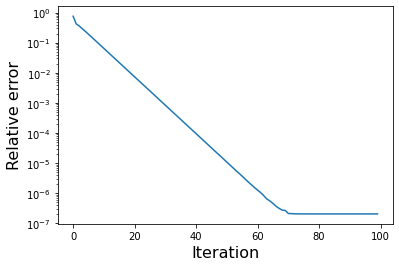

In [8]:
rel_error_ring = dview.pull('rel_error', block=True, targets=0)
plt.semilogy(rel_error_ring)
plt.xlabel('Iteration', fontsize=16)
plt.ylabel('Relative error', fontsize=16)

#### 2.7.3.2 Average consensus over 2D-mesh Grid

In [9]:
%%px

# Set topology as mesh grid topology.
G = topology_util.MeshGrid2DGraph(bf.size())
bf.set_topology(G, is_weightd=True)

maxite = 100
x = x0.clone()     # Initialize x as x0
rel_error = torch.zeros((maxite, 1))
for ite in range(maxite):
    
    if bf.rank()==0:
        if ite%10 == 0:
            print('Progress {}/{}'.format(ite, maxite))
        
    x, rel_error[ite] = avg_consensus_one_step(x)

CompositeError: one or more exceptions from call to method: execute
[0:execute]: TypeError: set_topology() got an unexpected keyword argument 'is_weightd'
[1:execute]: TypeError: set_topology() got an unexpected keyword argument 'is_weightd'
[2:execute]: TypeError: set_topology() got an unexpected keyword argument 'is_weightd'
[3:execute]: TypeError: set_topology() got an unexpected keyword argument 'is_weightd'
.... 4 more exceptions ...

In [ ]:
rel_error_grid = dview.pull('rel_error', block=True, targets=0)
plt.semilogy(rel_error_grid)
plt.xlabel('Iteration', fontsize=16)
plt.ylabel('Relative error', fontsize=16)

#### 2.7.3.3 Average consensus over exponential-two Grid

In [ ]:
%%px

# Set topology as exponential-two topology.
G = topology_util.ExponentialTwoGraph(bf.size())
bf.set_topology(G)

maxite = 100
x = x0.clone()     # Initialize x as x0
rel_error = torch.zeros((maxite, 1))
for ite in range(maxite):
    
    if bf.rank()==0:
        if ite%10 == 0:
            print('Progress {}/{}'.format(ite, maxite))
        
    x, rel_error[ite] = avg_consensus_one_step(x)

In [ ]:
rel_error_expo = dview.pull('rel_error', block=True, targets=0)
plt.semilogy(rel_error_expo)
plt.xlabel('Iteration', fontsize=16)
plt.ylabel('Relative error', fontsize=16)

From the figures in the above examples, it is found that the exponential-two topology, which has the smallest $\rho$, enables the fastest convergence.